<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [65]:
# Set your student number
student_number = 400101934
Name = 'Nikoo'
Last_Name = 'Moradi'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

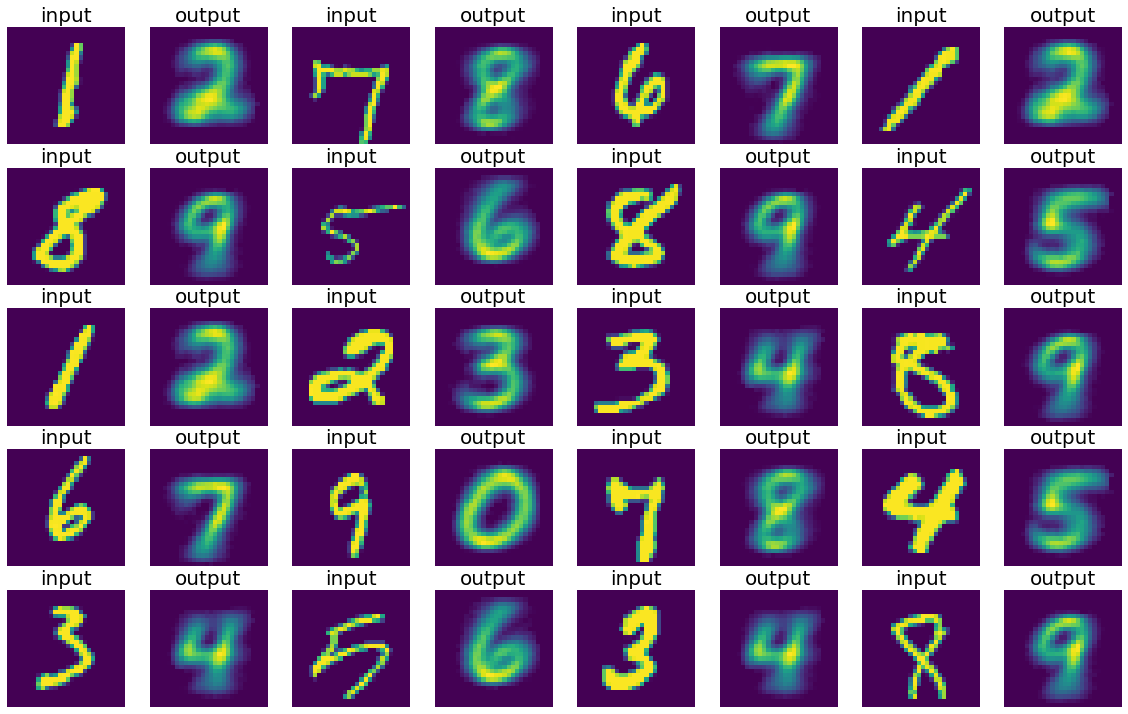

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [66]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [67]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: 32 x 7 x 7
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x 4 x 4
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 128 x 2 x 2
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x 4 x 4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32 x 8 x 8
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output: 16 x 15 x 15
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=1),  # Output: 1 x 28 x 28
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.encoder(x)
        x = self.decoder(x)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [68]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).unsqueeze(1)
        self.Y = torch.from_numpy(Y).unsqueeze(1)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [69]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0.0

    for X_batch, Y_batch, _ in dataloader:
        X_batch, Y_batch = X_batch.to(device, dtype=torch.float32), Y_batch.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = nn.MSELoss()(outputs, Y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)

    epoch_loss /= len(dataloader.dataset)
    return epoch_loss

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for X_batch, Y_batch, _ in dataloader:
            X_batch, Y_batch = X_batch.to(device, dtype=torch.float32), Y_batch.to(device, dtype=torch.float32)

            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, Y_batch)

            epoch_loss += loss.item() * X_batch.size(0)

    epoch_loss /= len(dataloader.dataset)
    return epoch_loss



## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [71]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, weight_decay=1e-5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [72]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

# Training loop
num_epochs = 16
best_val_loss = float('inf')
best_model_wts = None

for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = ae.state_dict()

# best model weights
if best_model_wts:
    ae.load_state_dict(best_model_wts)
    print(f'Best model loaded with validation loss: {best_val_loss:.4f}')
else:
    print('No improvement during training; final model is used.')



Epoch 1/16, Train Loss: 0.1168, Val Loss: 0.0678
Epoch 2/16, Train Loss: 0.0668, Val Loss: 0.0660
Epoch 3/16, Train Loss: 0.0652, Val Loss: 0.0641
Epoch 4/16, Train Loss: 0.0625, Val Loss: 0.0614
Epoch 5/16, Train Loss: 0.0601, Val Loss: 0.0594
Epoch 6/16, Train Loss: 0.0587, Val Loss: 0.0581
Epoch 7/16, Train Loss: 0.0576, Val Loss: 0.0572
Epoch 8/16, Train Loss: 0.0569, Val Loss: 0.0566
Epoch 9/16, Train Loss: 0.0564, Val Loss: 0.0563
Epoch 10/16, Train Loss: 0.0561, Val Loss: 0.0560
Epoch 11/16, Train Loss: 0.0558, Val Loss: 0.0558
Epoch 12/16, Train Loss: 0.0557, Val Loss: 0.0557
Epoch 13/16, Train Loss: 0.0555, Val Loss: 0.0555
Epoch 14/16, Train Loss: 0.0555, Val Loss: 0.0555
Epoch 15/16, Train Loss: 0.0553, Val Loss: 0.0554
Epoch 16/16, Train Loss: 0.0553, Val Loss: 0.0554
Best model loaded with validation loss: 0.0554


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [73]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
import os

# Save the best model
if best_model_wts is not None:
    os.makedirs('model_checkpoints', exist_ok=True)
    torch.save(best_model_wts, 'best_autoencoder_weights.pth')
    print(f'Best model saved with validation loss: {best_val_loss:.4f}')


ae = AutoEncoder().to(device)


ae.load_state_dict(torch.load('best_autoencoder_weights.pth'))

print("Best model state dictionary loaded successfully.")


Best model saved with validation loss: 0.0554
Best model state dictionary loaded successfully.


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


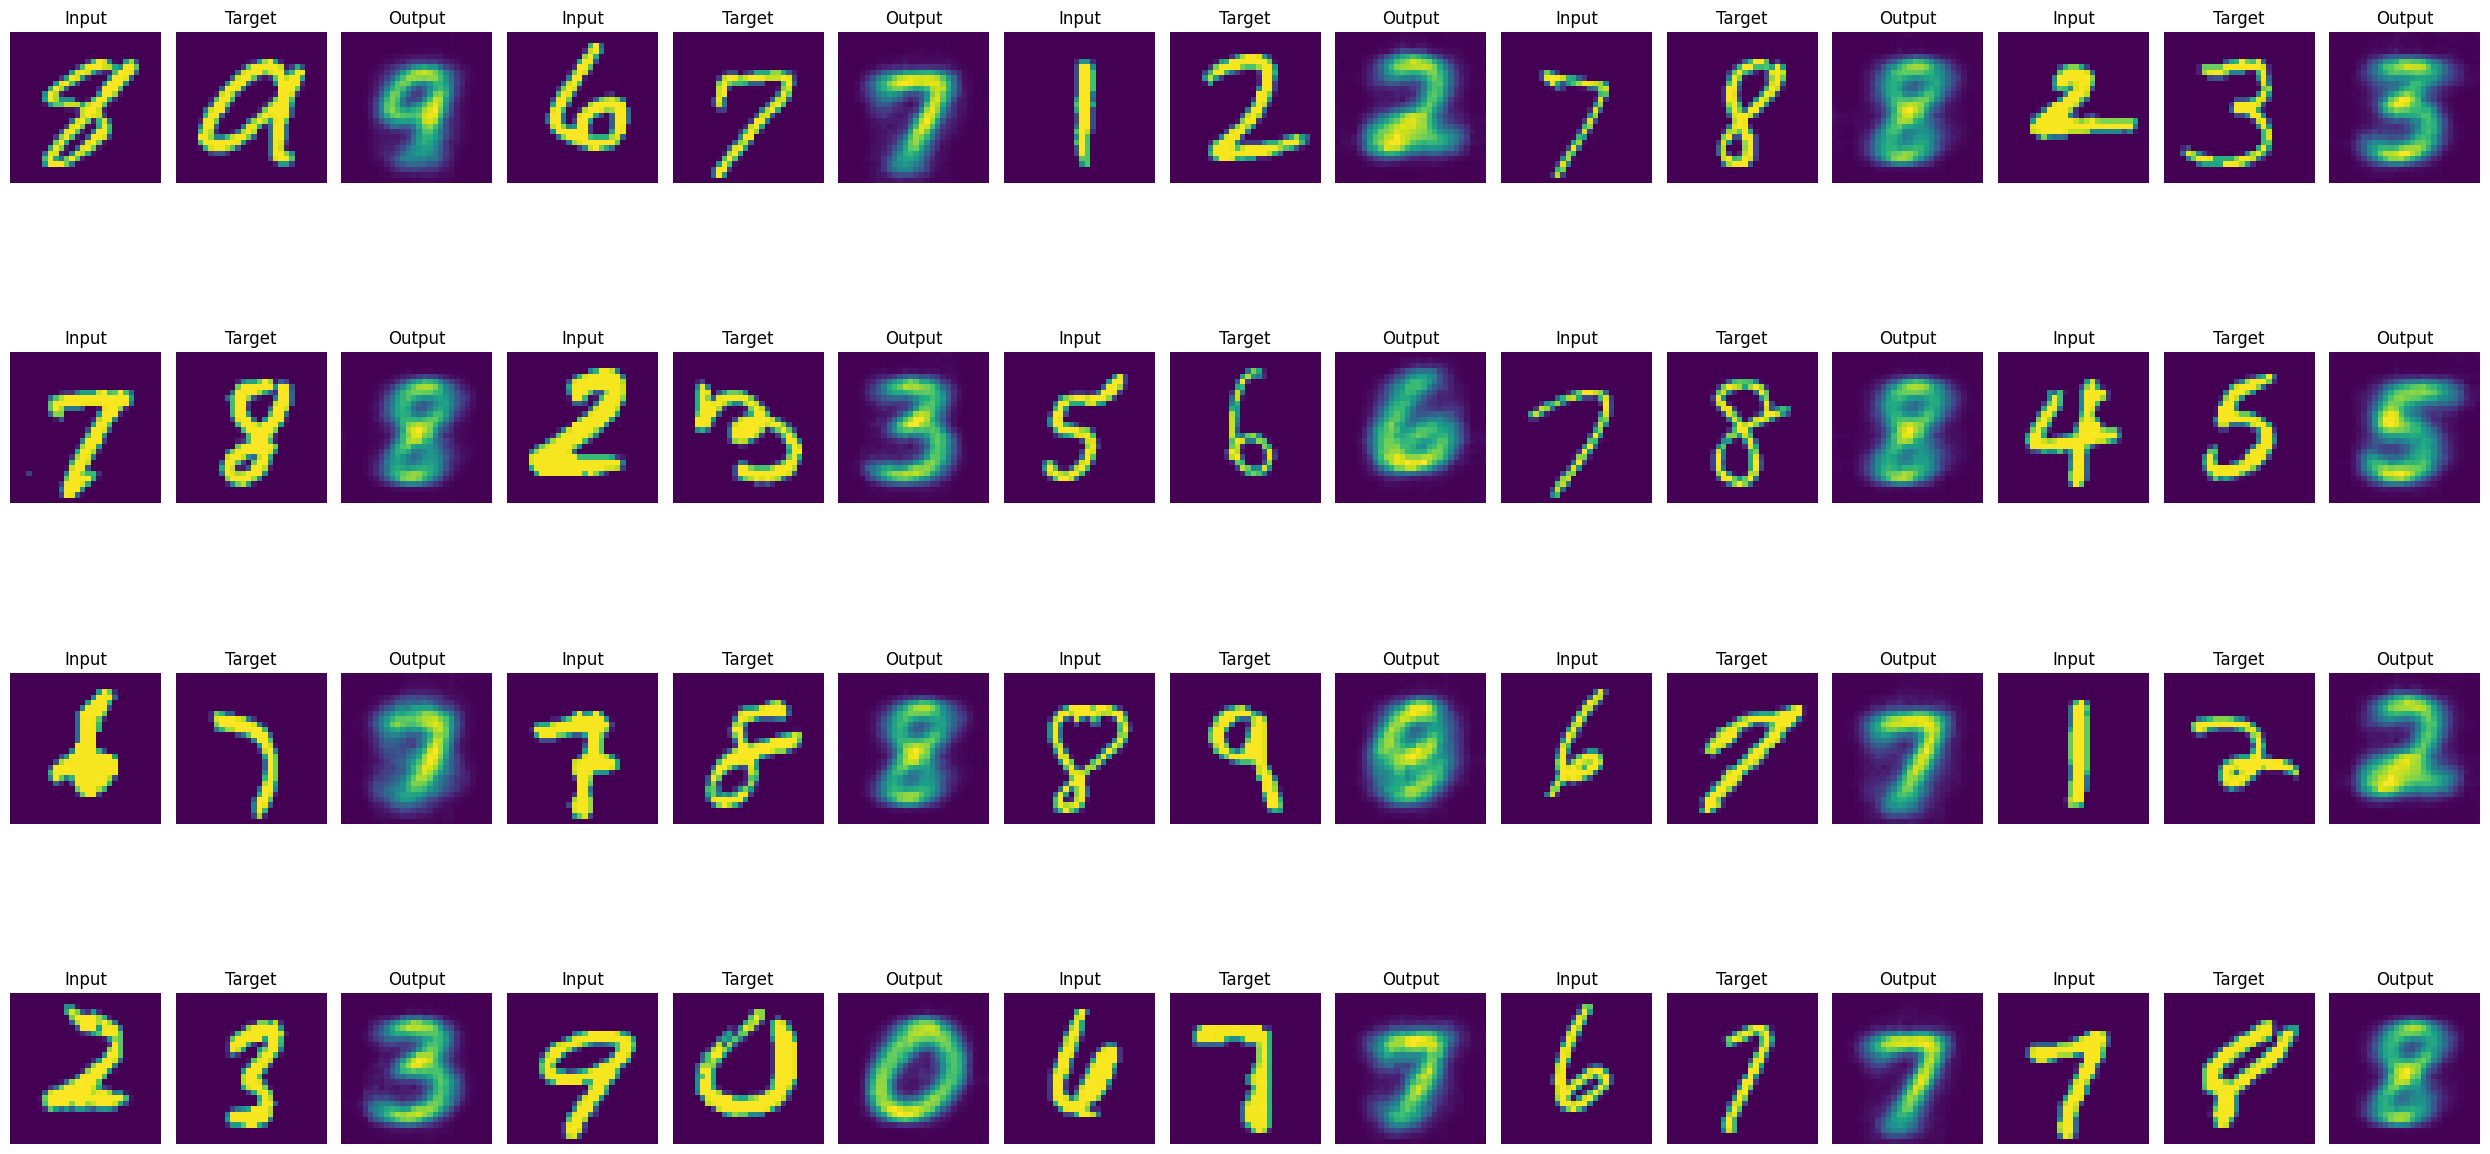

In [74]:
import matplotlib.pyplot as plt

X, Y, y = get_data()
_, X_test, _, Y_test, _, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)

test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=40,
    shuffle=True
)

ae.eval()
with torch.no_grad():
    for X_batch, Y_batch, _ in test_dataloader:
        X_batch, Y_batch = X_batch.to(device, dtype=torch.float32), Y_batch.to(device, dtype=torch.float32)
        outputs = ae(X_batch)
        break
X_batch = X_batch.cpu()
Y_batch = Y_batch.cpu()
outputs = outputs.cpu()

fig, axes = plt.subplots(4, 15, figsize=(25, 14))  # 8 rows and 15 columns for 40 images
axes = axes.ravel()

for i in range(20):
    # input image
    axes[3*i].imshow(X_batch[i].squeeze(), cmap='viridis')
    axes[3*i].set_title('Input')
    axes[3*i].axis('off')

    # target image
    axes[3*i+1].imshow(Y_batch[i].squeeze(), cmap='viridis')
    axes[3*i+1].set_title('Target')
    axes[3*i+1].axis('off')

    # output image
    axes[3*i+2].imshow(outputs[i].squeeze(), cmap='viridis')
    axes[3*i+2].set_title('Output')
    axes[3*i+2].axis('off')

plt.tight_layout()
plt.show()
